#### read the output file


- Load all the needed packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import main_single
from os.path import exists
import argparse
import matplotlib.pyplot as plt

import os, fnmatch

In [2]:
model_names = [ 'VRNN-Gauss', 'VRNN-Gauss-I', 'VRNN-GMM', 'VRNN-GMM-I', 'STORN']

In [3]:
# set the path
project_path = "./"
log_path = "log/single_phy_same_train_multi/toy_lgssm/"
# log_path = "multi_correct_para/toy_lgssm"
test_output_path = "/data/"

In [4]:
model_name = "VAE-RNN_None"

In [5]:
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                print(root,name)
                result.append(os.path.join(root, name))
    return result



### compare z_estimate and the z_KF 
(the model is VAE-RNN) 

In [8]:
# set the path
project_path = "./"
log_path = "log/single_phy_same_train_multi/toy_lgssm/"
# log_path = "multi_correct_para/toy_lgssm"
test_output_path = "/data/"
model_name = "VAE-RNN_None"

In [9]:

# model_name = model_names[1]
pattern = '*.csv'
path = project_path+log_path+model_name

a = find(pattern,path)

## get the RMSE

In [8]:
import numpy as np
# measurment update of KF
def KF_MU(C, R, y, P, xhat):
    # Kalman filter coefficient
    S = C.dot(P).dot(np.transpose(C)) + R
    K = P.dot(np.transpose(C)) * np.linalg.inv(S)

    # estimated observations
    yhat_ = C.dot(xhat)

    # measurement residual error (innovation error)
    innov = y - yhat_

    # updated estimate of the current state
    xhat = xhat + K.dot(innov)

    # updated state covariane matrix
    P = P - K.dot(C).dot(P)
    
    # TODO: check why the residual is calculated like this
    
    # updated (filtered) output estimate y(k|k)
    yhat = C.dot(xhat)
    print("KF_MU",yhat, "lalala",xhat, "lalala",P, K)
    return yhat, xhat, P, K


# time update of KF
def KF_TU(A, B, Q, P, xhat, u):
    # update of current state
    print("KF_TU",xhat, u)
    
    xhat = A.dot(xhat) + B.dot(u)

    # update of covariance
    P = A.dot(P).dot(np.transpose(A)) + Q
    print("KF_TU",xhat, P)

    return xhat, P

def run_kalman_filter(A, B, C, Q, R, u, y):
    # get simulation time
    k_max = u.shape[-1]
    print(k_max)
    # sizes
    # The lines `n_x = A.shape[-1]` and `n_y = C.shape[0]` are used to determine the dimensions of the
    # state vector `x` and the measurement vector `y` respectively.
    n_x = A.shape[-1]
    n_y = C.shape[0]

    # allocation
    xhat_list = np.zeros([k_max,n_x])
    yhat = np.zeros([n_y, k_max])
    xhat = np.zeros([n_x, 1])

    # initialization
    P = np.dot(B, np.transpose(B))

    for k in range(k_max):
        # measurement update
        yhat[:, k], xhat, P, K = KF_MU(C, R, y[:,k], P, xhat)

        # time update
        xhat, P = KF_TU(A, B, Q, P, xhat, [u[:,k]])
        # xhat_list[k] = xhat.transpose()

    return yhat

In [7]:
def run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out):
    # just a standard linear gaussian state space model. Measurement Noise is considered outside
    # same system as in toy examples of "Learning of state-space models with highly informative observations: a tempered
    # Sequential Monte Carlo solution", chapter 5.1
    # additionally measurement noise considered

    # get length of input
    k_max = u.shape[-1]

    # size of variables
    n_u = 1
    n_y = 1
    n_x = 2

    # allocation
    x = np.zeros([n_x, k_max + 1])
    y = np.zeros([n_y, k_max])

    # run over all time steps
    for k in range(k_max):
        x[:, k + 1] = np.dot(A, x[:, k]) + np.dot(B, u[:, k]).transpose() + sigma_state * np.random.randn(n_x)
        y[:, k] = np.dot(C, x[:, k])

    return y,x

In [10]:
# %% output the x, and y given A.B,C,D
A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [0]]).transpose()
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)
sigma_state = np.sqrt(0.25)
sigma_out = np.sqrt(1)
# y_kalman = run_kalman_filter(A, B, C, Q, R, df['u_test'], y_test_noisy)

In [11]:
# model_name = model_names[1]
pattern = '*.csv'
path = project_path+log_path+model_name+test_output_path

# a = find(pattern,path)

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/toy_lgssm_h80_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

u=df['u_test'].to_numpy().transpose()
y_kalman, x_kalman = run_kalman_filter(A, B, C, Q, R, df['u_test'], df['y_true'])
# y_kalman, x_kalman = run_kalman_filter(u, A, B, C, sigma_state, sigma_out)


In [156]:
matrix_2x1 = np.array([[2],
                       [3]])

# Define the 1x1 matrix
matrix_1x1 = np.array([[4]])
integer = [4]
result1 = np.dot(matrix_2x1, matrix_1x1)
result2 = np.dot(matrix_2x1, integer)
print("matrix_2x1 dot matrix_1x1:", result1, " shape:", result1.shape )
print(" shape matrix_1x1:", matrix_1x1.shape)
print("matrix_2x1 dot integer:", result2, " shape:",result2.shape)
print(" shape integer:", integer.shape )


matrix_2x1 dot matrix_1x1: [[ 8]
 [12]]  shape: (2, 1)
 shape matrix_1x1: (1, 1)
matrix_2x1 dot integer: [ 8 12]  shape: (2,)


AttributeError: 'list' object has no attribute 'shape'

In [16]:
x_kalman.shape
x_kf_0 = x_kalman.transpose()[0]
x_kf_1 = x_kalman.transpose()[1]


### plot function

In [12]:
def plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, length +1), x_kf_0[0:length], linestyle='dotted',color='orange',label='x_kf_0')
    plt.plot(range(1, length +1), x_kf_1[0:length], linestyle='dotted',color='blue',label='x_kf_1')
    plt.plot(range(1, length +1), x_nn_0[0:length], linestyle='-',color='orange',label='x_nn_0')
    plt.plot(range(1, length +1), x_nn_1[0:length], linestyle='-',color='blue',label='x_nn_1')

    plt.xlabel('k step')
    plt.ylabel('value')
    # plt.title('RMSE--RNN hiden states dimension')
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()
    
def plot_k_nn_x_y(x_kf_0,x_kf_1,x_nn_0,x_nn_1, y,length=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, length +1), x_kf_0[0:length], linestyle='dotted',color='orange',label='x_kf_0')
    plt.plot(range(1, length +1), x_kf_1[0:length], linestyle='dotted',color='blue',label='x_kf_1')
    plt.plot(range(1, length +1), x_nn_0[0:length], linestyle='-',color='orange',label='x_nn_0')
    plt.plot(range(1, length +1), x_nn_1[0:length], linestyle='-',color='blue',label='x_nn_1')
    plt.plot(range(1, length +1), y[0:length], linestyle='-',color='red',label='y')
    

    plt.xlabel('k step')
    plt.ylabel('value')
    # plt.title('RMSE--RNN hiden states dimension')
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

In [2]:
plot_k_nn_x(x_kf_0,x_kf_1,df['z_0'],df['z_1'], length=50)

NameError: name 'x_kf_0' is not defined

In [7]:
for root, dirs, files in os.walk(path):
        for name in files:
            print(root,name)

./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h40_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h4_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h58_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h39_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h3_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h42_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h11_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h17_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h52_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h57_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h31_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h80_z2_n1.log
./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h14_z2_n1.csv
./log/single_phy_cov/toy_lgssm/VAE-RNN_N

#### read rsme/std function

In [8]:
# pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/ toy_lgssm_h{}_z2_n1.csv"
def read_rsme(pattern, h_dim_max):
    rmse_value = []
    for i in range(1,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value

def read_rsme_every_5(pattern, h_dim_max ):
    rmse_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i*5))
        # print(i*5,df["rmse"])
        rmse_value.append(df["rmse"].mean()) 
    return rmse_value
    
def read_std(pattern, h_dim_max):
    std_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i))
        std_value.append(df["rmse"].std()) 
    return std_value

def read_std_every_5(pattern, h_dim_max ):
    std_value = []
    for i in range(2,h_dim_max+1):
        df = pd.read_csv(pattern.format(i*5))
        std_value.append(df["rmse"].std()) 
    return std_value



#### RMSE--RNN dim (0-80)
- normal
- spot only
- with the error bar

In [ ]:
pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/toy_lgssm_h{}_z2_n1.csv"

pd.read_csv(pattern.format(i*5))

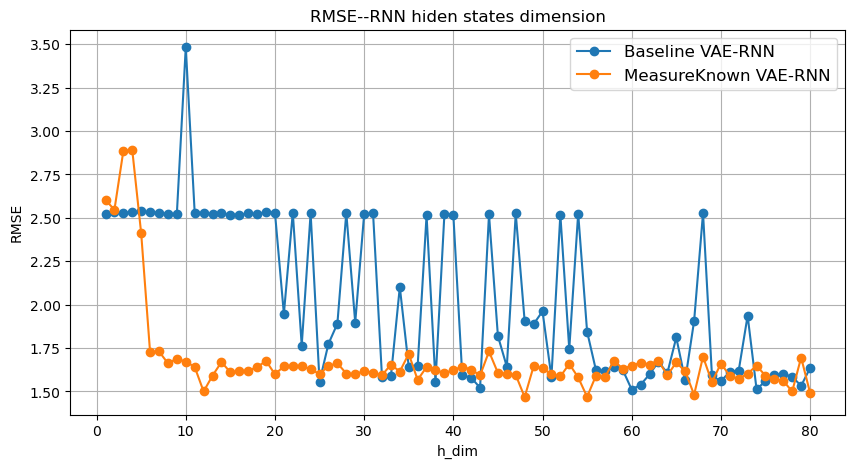

In [5]:
h_dim_max = 80

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/data/toy_lgssm_h{}_z2_n1.csv"
std_None_1 = read_std(pattern, h_dim_max)
rsme_None_1 = read_rsme(pattern, h_dim_max)

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN-PHY_None/data/toy_lgssm_h{}_z2_n1.csv"
std_Measure_1 = read_std(pattern, h_dim_max)
rsme_Measure_1 = read_rsme(pattern, h_dim_max)


plt.figure(figsize=(10, 5))
plt.plot(range(1, h_dim_max +1), rsme_None_1, marker='o', linestyle='-',label='Baseline VAE-RNN')
plt.plot(range(1, h_dim_max +1), rsme_Measure_1, marker='o', linestyle='-', label='MeasureKnown VAE-RNN')
plt.xlabel('h_dim')
plt.ylabel('RMSE')
plt.title('RMSE--RNN hiden states dimension')
plt.legend(fontsize='large')
plt.grid(True)
plt.show()

10 0    3.576961
1    2.333745
2    2.040377
3    3.535150
4    2.096078
Name: rmse, dtype: float64
15 0    2.644762
1    2.649723
2    1.946848
3    1.666917
4    1.752248
Name: rmse, dtype: float64
20 0    2.650119
1    2.645312
2    2.662973
3    2.648078
4    2.645946
Name: rmse, dtype: float64
25 0    2.643220
1    2.644999
2    1.642959
3    2.647405
4    2.645082
Name: rmse, dtype: float64
30 0    2.641728
1    2.640994
2    1.683322
3    2.639688
4    2.642422
Name: rmse, dtype: float64
35 0    1.733721
1    1.638430
2    1.662393
3    1.644258
4    2.620090
Name: rmse, dtype: float64
40 0    2.637932
1    2.644671
2    2.636734
3    2.654056
4    2.642360
Name: rmse, dtype: float64
45 0    1.843639
1    1.653188
2    1.936345
3    1.897714
4    1.959459
Name: rmse, dtype: float64
50 0    1.981164
1    1.812050
2    2.643366
3    2.662017
4    1.615453
Name: rmse, dtype: float64
55 0    1.797318
1    1.989032
2    1.663688
3    1.704647
4    1.806169
Name: rmse, dtype: float64


ValueError: x and y must have same first dimension, but have shapes (40,) and (39,)

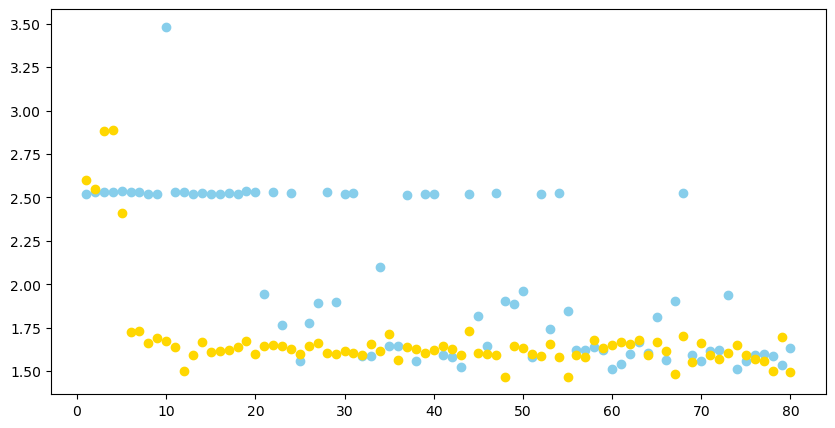

In [6]:
h_dim_max = 40

pattern = "./log/single_phy_same_train_multi/toy_lgssm_5_pre/VAE-RNN_None/toy_lgssm_5_pre_h{}_z2_n1_multitrain.csv"
std_None = read_std_every_5(pattern, h_dim_max)
rsme_None = read_rsme_every_5(pattern, h_dim_max)

pattern = "./log/single_phy_same_train_multi/toy_lgssm_5_pre/VAE-RNN-PHY_None/toy_lgssm_5_pre_h{}_z2_n1_multitrain.csv"
std_Measure = read_std_every_5(pattern, h_dim_max)
rsme_Measure = read_rsme_every_5(pattern, h_dim_max)


plt.figure(figsize=(10, 5))
# plt.plot(range(1, 80 +1), rsme_None_1, marker='o', color = "skyblue" ,linestyle='-',label='Baseline VAE-RNN')
# plt.plot(range(1, 80 +1), rsme_Measure_1, marker='o', linestyle='-', color="gold",label='MeasureKnown VAE-RNN')
# plt.plot(list(range(5,(h_dim_max+1)*5))[0::5], rsme_None, marker='o', linestyle='-',  color = "tab:blue", label='Baseline VAE-RNN')
# plt.plot(list(range(5,(h_dim_max+1)*5))[0::5], rsme_Measure, marker='o', linestyle='-',color = "tab:orange", label='MeasureKnown VAE-RNN')

plt.plot(range(1, 80 +1), rsme_None_1, marker='o', color = "skyblue" ,label='Baseline', linestyle='None',)
plt.plot(range(1, 80 +1), rsme_Measure_1, marker='o',  color="gold",label='MeasureKnown', linestyle='None',)
plt.plot(list(range(5,(h_dim_max+1)*5))[0::5], rsme_None, marker='o',   color = "tab:blue", label='Baseline (every 5th)',)
plt.plot(list(range(5,(h_dim_max+1)*5))[0::5], rsme_Measure, marker='o', color = "tab:orange", label='MeasureKnown (every 5th)')

plt.xlabel('h_dim')
plt.ylabel('RMSE')
plt.title('RMSE--RNN hiden states dimension (VAE-RNN model)')
plt.legend(fontsize='large')
ax = plt.gca()
ax.set_xlim([0, 210])
plt.show()


## std should also be included

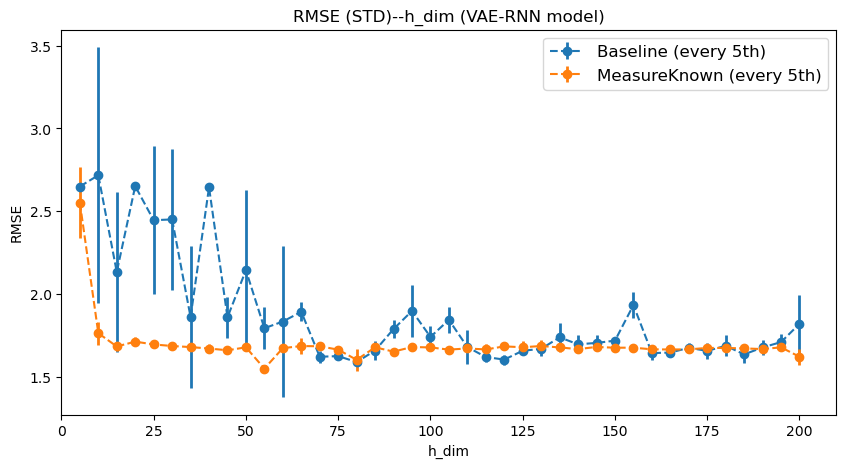

In [6]:
plt.figure(figsize=(10, 5))
plt.errorbar(list(range(5,(h_dim_max+1)*5))[0::5], rsme_None, std_None, marker='o',   color = "tab:blue", label='Baseline (every 5th)',linestyle="--",elinewidth=2)
plt.errorbar(list(range(5,(h_dim_max+1)*5))[0::5], rsme_Measure, std_Measure, marker='o', color = "tab:orange", label='MeasureKnown (every 5th)',linestyle="--",elinewidth=2)

plt.xlabel('h_dim')
plt.ylabel('RMSE')
plt.title('RMSE (STD)--h_dim (VAE-RNN model)')
plt.legend(fontsize='large')
ax = plt.gca()
ax.set_xlim([0, 210])
plt.show()

#### RMSE--RNN dim (y is 2 × 1)

10 0    1.880885
1    1.144246
2    1.920022
3    1.176829
4    1.939404
5    1.166760
6    1.940883
7    1.177655
8    1.953270
9    1.179147
Name: rmse, dtype: float64
15 0    2.416945
1    1.120504
2    2.396775
3    1.119796
4    2.396164
5    1.120121
6    2.404556
7    1.119849
8    2.399683
9    1.120853
Name: rmse, dtype: float64
20 0    2.413376
1    1.120658
2    2.396138
3    1.119771
4    2.397835
5    1.120097
6    2.410099
7    1.119836
8    2.399110
9    1.120692
Name: rmse, dtype: float64
25 0    2.407435
1    1.120465
2    2.395067
3    1.119399
4    2.394994
5    1.119847
6    2.388711
7    1.119762
8    2.396735
9    1.119834
Name: rmse, dtype: float64
30 0    1.950937
1    1.199544
2    2.397852
3    1.120458
4    1.780062
5    1.144641
6    2.378025
7    1.119770
8    1.914603
9    1.190519
Name: rmse, dtype: float64
35 0    1.936358
1    1.596168
2    2.387737
3    1.120816
4    2.394911
5    1.120161
6    1.635177
7    1.131221
8    2.398309
9    1.120417
Name: r

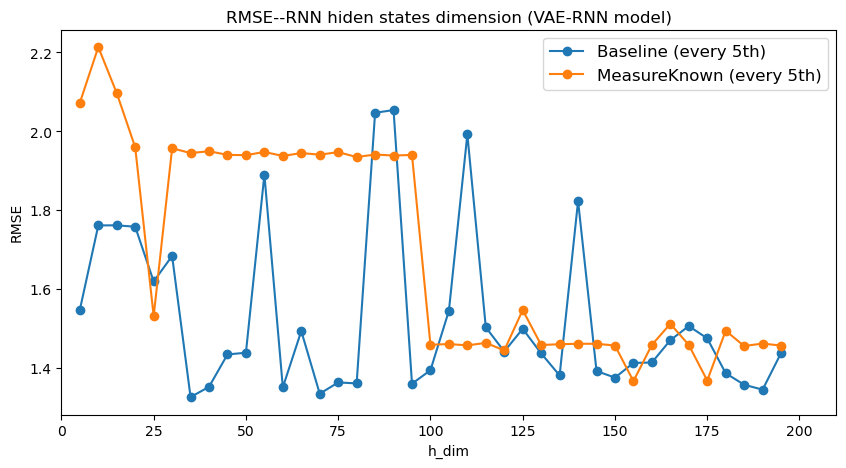

In [23]:
h_dim_max = 40

pattern = "./log/single_phy_same_train_multi/toy_lgssm_2dy_5_pre/VAE-RNN_None/toy_lgssm_2dy_5_pre_h{}_z2_n1_multitrain.csv"
std_None = read_std_every_5(pattern, h_dim_max)
rsme_None = read_rsme_every_5(pattern, h_dim_max)

pattern = "./log/single_phy_same_train_multi/toy_lgssm_2dy_5_pre/VAE-RNN-PHY_None/toy_lgssm_2dy_5_pre_h{}_z2_n1_multitrain.csv"
std_Measure = read_std_every_5(pattern, h_dim_max)
rsme_Measure = read_rsme_every_5(pattern, h_dim_max)


plt.figure(figsize=(10, 5))

## plot with the errorbar
#
# plt.errorbar(list(range(5,(h_dim_max)*5))[0::5], rsme_None, std_None, marker='o',   color = "tab:blue", label='Baseline (every 5th)',linestyle="--",elinewidth=2)
# plt.errorbar(list(range(5,(h_dim_max)*5))[0::5], rsme_Measure, std_Measure, marker='o', color = "tab:orange", label='MeasureKnown (every 5th)',linestyle="--",elinewidth=2)


## plot without errorbar
plt.plot(list(range(5,(h_dim_max)*5))[0::5], rsme_None, marker='o',   color = "tab:blue", label='Baseline (every 5th)',)
plt.plot(list(range(5,(h_dim_max)*5))[0::5], rsme_Measure, marker='o', color = "tab:orange", label='MeasureKnown (every 5th)')

plt.xlabel('h_dim')
plt.ylabel('RMSE')
plt.title('RMSE--RNN hiden states dimension (VAE-RNN model)')
plt.legend(fontsize='large')
ax = plt.gca()
ax.set_xlim([0, 210])
plt.show()


## std should also be included

### the mean markdown performance

In [14]:
sum(rsme_None)/len(rsme_None)
rsme_None[79]

1.6340831009034626

In [21]:
sum(rsme_Measure)/len(rsme_Measure)
rsme_Measure[79]
for i in range(0,len(rsme_Measure)):
    if rsme_Measure[i]==min(rsme_Measure):
        print(i)
count = 0
for i in range(0,len(rsme_Measure)):
    if rsme_Measure[i]>rsme_None[i]:
        print(i, rsme_Measure[i],rsme_None[i])
        count+=1
print(count)
min(rsme_Measure)


47
0 2.6026887100258773 2.5190691822620606
1 2.5459626923275436 2.5306289518701712
2 2.8842737115004886 2.5292277099096547
3 2.8897996891246622 2.5307824278633815
24 1.6001586604260862 1.5565424788741884
31 1.5929202739472728 1.5849587499624662
32 1.6549496315621326 1.586115143355722
34 1.7165505550774927 1.642920574292802
37 1.62510796180088 1.556808471397599
40 1.64232367008468 1.5941673692751892
41 1.6261682014567984 1.578644082790879
42 1.591789582739376 1.521622345458307
50 1.5992237914038927 1.5827773272648133
57 1.6770165880533328 1.6411446979304736
58 1.6311027146808734 1.6235092690180992
59 1.648107455274081 1.5111237000396827
60 1.6665026838224564 1.5382986353371009
61 1.6549524052924902 1.5984097239157014
62 1.6765032170325411 1.6703016906044958
65 1.6150500861470847 1.5651309504990825
69 1.6606371002565061 1.5580785382349505
73 1.6480454080929423 1.5133081156043673
74 1.5908376476209536 1.5584488465770998
78 1.6952942630207937 1.5325098343800112
24


1.4674667584475762

## generate new training dataset (same system as the baseline model)

In [1]:
import numpy as np
import pandas as pd
def run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out):
    # get length of input
    k_max = u.shape[-1]

    # size of variables
    n_u = 1
    n_y = 1
    n_x = 2

    # allocation
    x = np.zeros([n_x, k_max + 1])
    y = np.zeros([n_y, k_max])

    # run over all time steps
    for k in range(k_max):
        x[:, k + 1] = np.dot(A, x[:, k]) + np.dot(B, u[:, k]) + sigma_state * np.random.randn(n_x)
        y[:, k] = np.dot(C, x[:, k])

    return x, y

def create_toy_lgssm_5_datasets_uyx(seq_len_train=None, seq_len_val=None, seq_len_test=None, **kwargs):
    # state space matrices
    A = np.array([[0.7, 0.8], [0, 0.1]])
    B = np.array([[-1], [0.1]])
    C = np.array([[1], [0]]).transpose()
    # C = np.array([[1], [-1]]).transpose()
    # define noise
    sigma_state = np.sqrt(0.25)
    sigma_out = np.sqrt(1)

    # length of all data sets
    if bool(kwargs) and ("k_max_train" in kwargs):
        k_max_train = kwargs['k_max_train']
        k_max_val = kwargs['k_max_val']
        k_max_test = kwargs['k_max_test']
    else:
        # Default option
        k_max_train = 2000
        k_max_val = 2000
        k_max_test = 5000

    u_train = (np.random.rand(1, k_max_train) - 0.5) * 5
    u_val = (np.random.rand(1, k_max_val) - 0.5) * 5
    # get the outputs
    x_train,y_train = run_toy_lgssm_sim(u_train, A, B, C, sigma_state, 0) 
    x_val,y_val = run_toy_lgssm_sim(u_val, A, B, C, sigma_state, 0) 
    y_train = y_train +  sigma_out * np.random.randn(1, k_max_train)
    y_val = y_val + sigma_out * np.random.randn(1, k_max_train)

    return u_train, u_val, y_train, y_val, x_train, x_val

def generate_lgssm_multi(file_path,number=5,length=5000):
    for i in range(0,number):
        u_train, u_val, y_train, y_val, x_train, x_val = create_toy_lgssm_5_datasets_uyx()
        u_train = u_train.transpose(1, 0)
        y_train = y_train.transpose(1, 0)
        x_train = x_train.transpose(1, 0)
        u_val = u_val.transpose(1, 0)
        y_val = y_val.transpose(1, 0)
        x_val = x_val.transpose(1, 0)
        np.savez(file_path.format(i), u_train =  u_train,
                                      y_train = y_train,
                                      x_train = x_train,
                                      u_val = u_val,
                                      y_val = y_val,
                                      x_val = x_val)



In [37]:
import numpy as np
import pandas as pd
def run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out):
    # get length of input
    k_max = u.shape[-1]

    # size of variables
    n_u = 1
    n_y = 1
    n_x = 2

    # allocation
    x = np.zeros([n_x, k_max])
    y = np.zeros([n_y, k_max])

    # run over all time steps
    for k in range(k_max):
        if k==0:
            x_km1 = np.zeros([n_x])
        else:
            x_km1 = x[:, k-1]
        print(k,np.dot(A, x_km1),np.dot(B, u[:, k]),sigma_state * np.random.randn(n_x),np.dot(A, x_km1).shape,np.dot(B, u[:, k]).shape,(sigma_state * np.random.randn(n_x)).shape)
        print((np.dot(A, x_km1) + np.dot(B, u[:, k]) + sigma_state * np.random.randn(n_x)))
        x[:, k] = np.dot(A, x_km1) + np.dot(B, u[:, k]) + sigma_state * np.random.randn(n_x)
        y[:, k] = np.dot(C, x[:, k])

    return x, y

def create_toy_lgssm_5_datasets_uyx(seq_len_train=None, seq_len_val=None, seq_len_test=None, **kwargs):
    # state space matrices
    A = np.array([[0.7, 0.8], [0, 0.1]])
    B = np.array([[-1], [0.1]])
    C = np.array([[1], [0]]).transpose()
    # C = np.array([[1], [-1]]).transpose()
    # define noise
    sigma_state = np.sqrt(0.25)
    sigma_out = np.sqrt(1)

    # length of all data sets
    if bool(kwargs) and ("k_max_train" in kwargs):
        k_max_train = kwargs['k_max_train']
        k_max_val = kwargs['k_max_val']
        k_max_test = kwargs['k_max_test']
    else:
        # Default option
        k_max_train = 2000
        k_max_val = 2000
        k_max_test = 5000

    u_train = (np.random.rand(1, k_max_train) - 0.5) * 5
    u_val = (np.random.rand(1, k_max_val) - 0.5) * 5
    # get the outputs
    x_train,y_train = run_toy_lgssm_sim(u_train, A, B, C, sigma_state, 0) 
    x_val,y_val = run_toy_lgssm_sim(u_val, A, B, C, sigma_state, 0) 
    y_train = y_train +  sigma_out * np.random.randn(1, k_max_train)
    y_val = y_val + sigma_out * np.random.randn(1, k_max_val)

    return u_train, u_val, y_train, y_val, x_train, x_val

def generate_lgssm_multi(file_path,number=5):
    for i in range(0,number):
        u_train, u_val, y_train, y_val, x_train, x_val = create_toy_lgssm_5_datasets_uyx()
        u_train = u_train.transpose(1, 0)
        y_train = y_train.transpose(1, 0)
        x_train = x_train.transpose(1, 0)
        u_val = u_val.transpose(1, 0)
        y_val = y_val.transpose(1, 0)
        x_val = x_val.transpose(1, 0)
        np.savez(file_path.format(i), u_train =  u_train,
                                      y_train = y_train,
                                      x_train = x_train,
                                      u_val = u_val,
                                      y_val = y_val,
                                      x_val = x_val)
        
def generate_lgssm_test(file_path,number=5,length=20000):
    for i in range(0,number):
        u_train, u_val, y_train, y_val, x_train, x_val = create_toy_lgssm_5_datasets_uyx(k_max_train = 20000, k_max_val=0,k_max_test=0)
        u_test = u_train.transpose(1, 0)
        y_test = y_train.transpose(1, 0)
        x_test = x_train.transpose(1, 0)

        np.savez(file_path, u_test =  u_test,
                                      y_test = y_test,
                                      x_test = x_test,)



In [39]:
# dont run this!!!!
'''
file_path = 'data/Toy_LGSSM/toy_lgssm_pre_testset_shifted.npz'
generate_lgssm_test(file_path)


file_path = 'data/Toy_LGSSM/toy_lgssm_pre_trainingset_shifted_{}.npz'
generate_lgssm_multi(file_path)
'''

"\nfile_path = 'data/Toy_LGSSM/toy_lgssm_pre_testset_shifted.npz'\ngenerate_lgssm_test(file_path)\n\n\nfile_path = 'data/Toy_LGSSM/toy_lgssm_pre_trainingset_shifted_{}.npz'\ngenerate_lgssm_multi(file_path)\n"

In [7]:
import numpy as np
import pandas as pd

def run_toy_lgssm_2dy_sim(u, A, B, C, sigma_state, sigma_out):
    # get length of input
    k_max = u.shape[-1]

    # size of variables
    n_u = 1
    n_y = 2
    n_x = 2

    # allocation
    x = np.zeros([n_x, k_max + 1])
    y = np.zeros([n_y, k_max])

    # run over all time steps
    for k in range(k_max):
        x[:, k + 1] = np.dot(A, x[:, k]) + np.dot(B, u[:, k]) + sigma_state * np.random.randn(n_x)
        y[:, k] = np.dot(C, x[:, k])

    return x, y

def create_toy_lgssm_5_datasets_2dy_uyx(seq_len_train=None, seq_len_val=None, seq_len_test=None, **kwargs):
    # state space matrices
    A = np.array([[0.7, 0.8], [0, 0.1]])
    B = np.array([[-1], [0.1]])
    C = np.array([[1, 0], [0,1]]).transpose()
    # C = np.array([[1], [-1]]).transpose()
    # define noise
    sigma_state = np.sqrt(0.25)
    sigma_out = np.sqrt(1)

    # length of all data sets
    if bool(kwargs) and ("k_max_train" in kwargs):
        k_max_train = kwargs['k_max_train']
        k_max_val = kwargs['k_max_val']
        k_max_test = kwargs['k_max_test']
    else:
        # Default option
        k_max_train = 2000
        k_max_val = 2000
        k_max_test = 5000

    u_train = (np.random.rand(1, k_max_train) - 0.5) * 5
    u_val = (np.random.rand(1, k_max_val) - 0.5) * 5
    # get the outputs
    x_train,y_train = run_toy_lgssm_2dy_sim(u_train, A, B, C, sigma_state, 0) 
    x_val,y_val = run_toy_lgssm_2dy_sim(u_val, A, B, C, sigma_state, 0) 
    y_train = y_train +  sigma_out * np.random.randn(1, k_max_train)
    y_val = y_val + sigma_out * np.random.randn(1, k_max_train)

    return u_train, u_val, y_train, y_val, x_train, x_val

def generate_lgssm_multi_2dy(file_path,number=5,length=5000):
    for i in range(0,number):
        u_train, u_val, y_train, y_val, x_train, x_val = create_toy_lgssm_5_datasets_2dy_uyx()
        u_train = u_train.transpose(1, 0)
        y_train = y_train.transpose(1, 0)
        x_train = x_train.transpose(1, 0)
        u_val = u_val.transpose(1, 0)
        y_val = y_val.transpose(1, 0)
        x_val = x_val.transpose(1, 0)
        np.savez(file_path.format(i), u_train =  u_train,
                                      y_train = y_train,
                                      x_train = x_train,
                                      u_val = u_val,
                                      y_val = y_val,
                                      x_val = x_val)
                                                        
         
# file_path = 'data/Toy_LGSSM/toy_lgssm_2dy_pre_trainingset_{}.npz'
# generate_lgssm_multi_2dy(file_path)

In [8]:
def generate_lgssm_multi_2dy_test(file_path,number=5,length=5000):
    for i in range(0,number):
        u_train, u_val, y_train, y_val, x_train, x_val = create_toy_lgssm_5_datasets_2dy_uyx()
        u_train = u_train.transpose(1, 0)
        y_train = y_train.transpose(1, 0)
        x_train = x_train.transpose(1, 0)
        u_val = u_val.transpose(1, 0)
        y_val = y_val.transpose(1, 0)
        x_val = x_val.transpose(1, 0)
        np.savez(file_path.format(i), u_test = u_train,
                                      y_test = y_train,
                                      x_test = x_train,)

# file_path = 'data/Toy_LGSSM/toy_lgssm_2dy_testing.npz'
# generate_lgssm_multi_2dy_test(file_path,number=1,length=50000)

In [84]:

test_data = np.load(file_path)
u=test_data['u_test'].transpose()

In [149]:
 # allocation
def run_kalman_filter(A, B, C, Q, R, u, y):
    # get simulation time
    k_max = u.shape[-1]

    # sizes
    # The lines `n_x = A.shape[-1]` and `n_y = C.shape[0]` are used to determine the dimensions of the
    # state vector `x` and the measurement vector `y` respectively.
    n_x = A.shape[-1]
    n_y = C.shape[0]

    # allocation
    xhat = np.zeros([n_x, 1])
    yhat = np.zeros([n_y, k_max])

    # initialization
    P = np.dot(B, np.transpose(B))

    for k in range(k_max):
        # measurement update
        yhat[:, k], xhat, P, K = KF_MU(C, R, y[:, k], P, xhat)

        # time update
        xhat, P = KF_TU(A, B, Q, P, xhat, [u[:,  k]])

    return yhat

A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
# C = np.array([[1], [0]]).transpose()
C = np.array([[1], [-1]]).transpose()
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)
y_kalman = run_kalman_filter(A, B, C, Q, R, test_data["u_train"].transpose(), test_data["y_train"].transpose())

KF_MU [[0.01815639]] lalala [[ 0.01650581]
 [-0.00165058]] lalala [[ 0.45248869 -0.04524887]
 [-0.04524887  0.00452489]] [[ 0.49773756]
 [-0.04977376]]
KF_TU [[ 0.01650581]
 [-0.00165058]] [array([0.65381007])]
KF_TU [[-0.64357646]
 [ 0.06521595]] [[ 0.67393665 -0.00280543]
 [-0.00280543  0.50004525]]
KF_MU [[-0.92877578]] lalala [[-0.76978273]
 [ 0.15899305]] lalala [[0.4638149  0.15332475]
 [0.15332475 0.3840333 ]] [[ 0.31049015]
 [-0.23070855]]
KF_TU [[-0.76978273]
 [ 0.15899305]] [array([0.3525842])]
KF_TU [[-0.76423768]
 [ 0.05115773]] [[1.14477434 0.0414554 ]
 [0.0414554  0.50384033]]
KF_MU [[-2.10257304]] lalala [[-1.67128497]
 [ 0.43128807]] lalala [[0.67031869 0.24029286]
 [0.24029286 0.42051044]] [[ 0.43002583]
 [-0.18021758]]
KF_TU [[-1.67128497]
 [ 0.43128807]] [array([-1.16798152])]
KF_TU [[ 0.34311249]
 [-0.07366934]] [[1.36671085 0.05046134]
 [0.05046134 0.5042051 ]]
KF_MU [[2.13885939]] lalala [[ 1.62372963]
 [-0.51512976]] lalala [[0.74125345 0.26607197]
 [0.26607197 0

### different measurement matrix

In [10]:
import numpy as np
# file_path = 'data/Toy_LGSSM/toy_lgssm_testdata_identical.npz'
file_path = 'data/Toy_LGSSM/toy_lgssm_testdata.npz'

test_data = np.load(file_path)
u=test_data['u_test'].transpose()


#### redefine the state space model

In [46]:
A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [-1]]).transpose() # C was redefined
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)

# y_kalman, x_kalman = run_kalman_filter(A, B, C, Q, R, df['u_test'], df['y_true'])
y_sim, x_sim = run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out)
y_sim = y_sim + sigma_out * np.random.randn(1, y_sim.shape[-1])
# save the new dataset
file_new_path = 'data/Toy_LGSSM/toy_lgssm_testdata_identical.npz'
# np.savez(file_new_path, u_test=npz_kw['u_test'], y_test=npz_kw['y_test'],x_sim = x_sim)
npz_kw = np.load(file_new_path)
print(npz_kw.files)

['u_test', 'y_test', 'x_sim']


In [43]:
x_sim

array([[ 0.        , -0.19066938, -1.23858904, ...,  3.05672491,
         3.97687838,  3.57148775],
       [ 0.        , -0.28012864,  0.8090414 , ...,  0.22273795,
         0.23270429, -0.03698765]])

In [5]:
def plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, length +1), x_kf_0[0:length], linestyle='dotted',color='orange',label='x_kf_0')
    plt.plot(range(1, length +1), x_kf_1[0:length], linestyle='dotted',color='blue',label='x_kf_1')
    plt.plot(range(1, length +1), x_nn_0[0:length], linestyle='-',color='orange',label='x_nn_0')
    plt.plot(range(1, length +1), x_nn_1[0:length], linestyle='-',color='blue',label='x_nn_1')

    plt.xlabel('k step')
    plt.ylabel('value')
    # plt.title('RMSE--RNN hiden states dimension')
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

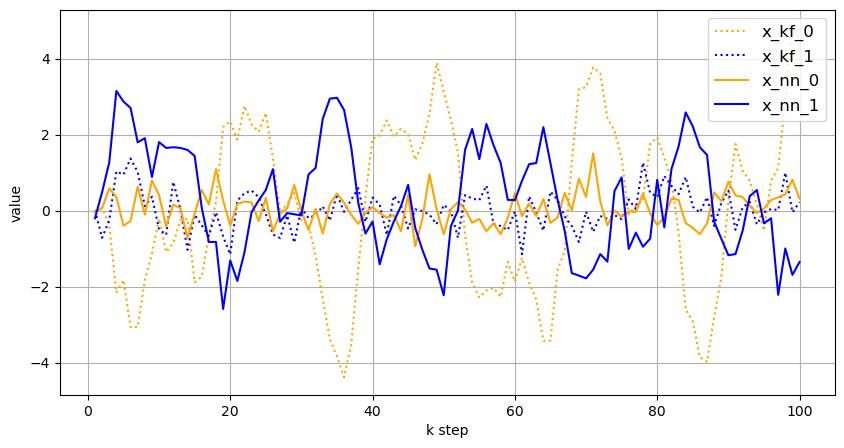

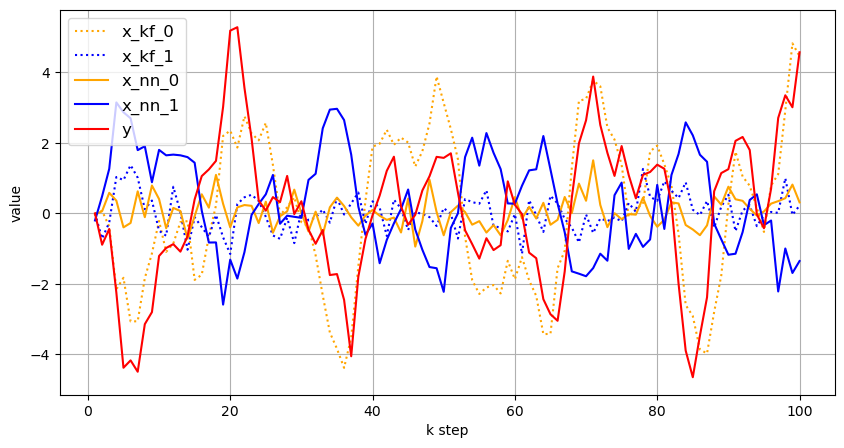

In [13]:

# This is non-physical embedded model
# we found the training data is 

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN_None/toy_lgssm_h80_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [0]]).transpose()
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)
sigma_state = np.sqrt(0.25)
sigma_out = np.sqrt(1)


y_sim, x_sim = run_toy_lgssm_sim(u, A, B, C, sigma_state, sigma_out)
# y_kalman, x_kalman = run_kalman_filter(A, B, C, Q, R, u, df["y_true_with_noise"])
x_kf_0 = x_sim[0]
x_kf_1 = x_sim[1]
x_nn_0 = df["z_0"][1:]
x_nn_1 = df["z_1"][1:]
y=df["y_true"]
plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=100)

plot_k_nn_x_y(x_kf_0,x_kf_1,x_nn_0,x_nn_1,y, length=100)

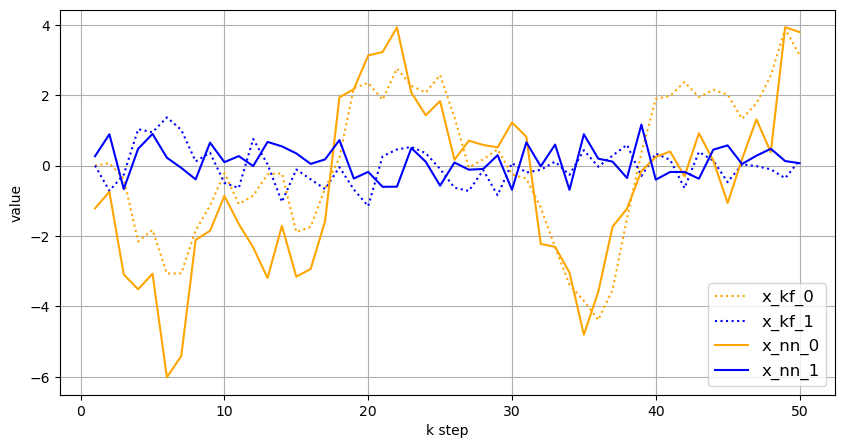

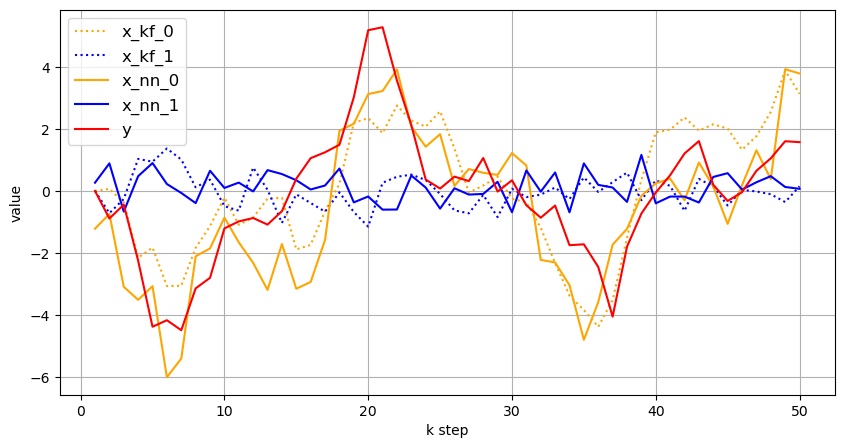

1.222110760420459


In [21]:
pattern = "./log/single_phy_idmaC/toy_lgssm/VAE-RNN-PHY_None/toy_lgssm_h60_z2_n1.csv"
df = pd.read_csv(pattern)
x_kf_0 = x_sim[0]
x_kf_1 = x_sim[1]
x_nn_0 = df["z_0"]
x_nn_1 = df["z_1"]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)
plot_k_nn_x_y(x_kf_0,x_kf_1,x_nn_0,x_nn_1,y, length=50)

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(x_nn_0[:5000],x_kf_0[:5000]))
print(rms)


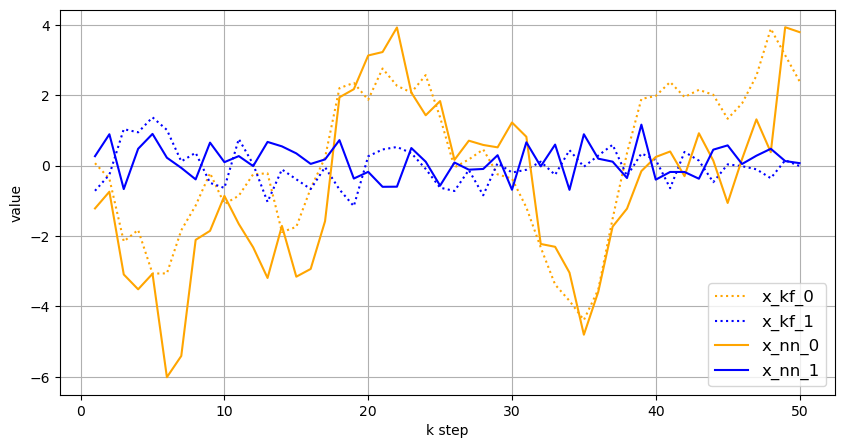

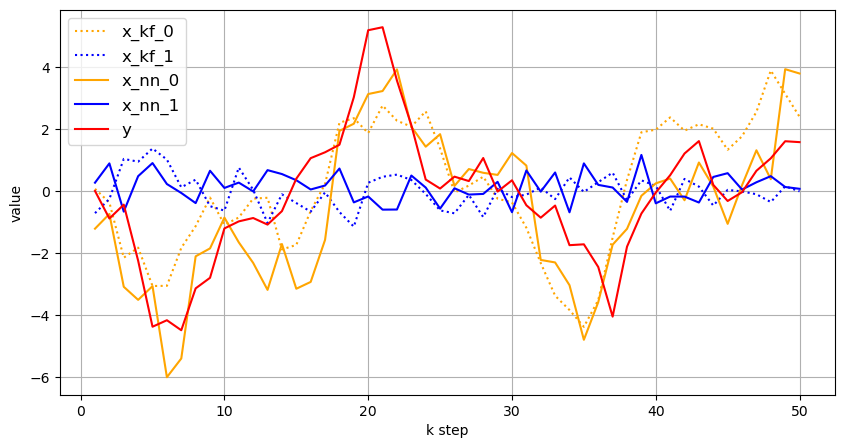

1.4832042949649513


In [23]:
pattern = "./log/single_phy_idmaC/toy_lgssm/VAE-RNN-PHY_None/toy_lgssm_h60_z2_n1.csv"
df = pd.read_csv(pattern)
x_kf_0 = x_sim[0][1:]
x_kf_1 = x_sim[1][1:]
x_nn_0 = df["z_0"][:-1]
x_nn_1 = df["z_1"][:-1]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)
plot_k_nn_x_y(x_kf_0,x_kf_1,x_nn_0,x_nn_1,y, length=50)


print(rms)


In [39]:
def npz_y_test():
    file_new_path = 'data/Toy_LGSSM/toy_lgssm_testdata.npz'
    np.savez(file_new_path, u_test=test_data['u_test'], y_test=y_sim.transpose())
    npz_kw = np.load(file_new_path)
    print(npz_kw["u_test"])
    print(npz_kw["y_test"])
npz_y_test()

[[ 0.        ]
 [ 0.83647514]
 [ 1.43281019]
 ...
 [-1.63560362]
 [-1.43281019]
 [-0.83647514]]
[[-0.49565518]
 [-1.13046876]
 [-0.61903951]
 ...
 [ 2.31541856]
 [ 1.63262141]
 [ 3.36414932]]


In [41]:
df

,Unnamed: 0,u_test,y_true,y_true_with_noise,y_predict_mu,y_predict_sigma,z_0,z_1
0,0,0.000000,0.000000,-1.473179,0.102809,1.150823,1.215642,0.074015
1,1,0.836475,-0.889567,1.712950,1.027605,1.113881,-0.036228,-0.200555
2,2,1.432810,-0.441679,-2.207763,-0.288578,1.117739,0.063897,0.487584
3,3,1.635604,-2.250232,-2.705119,-1.607768,1.174161,0.583349,1.265068
4,4,1.432113,-4.382381,-3.877919,-4.590371,1.140256,0.362190,3.150032
...,...,...,...,...,...,...,...,...
4995,4995,-0.951057,0.618047,1.256455,0.175375,1.088899,0.013111,0.230954
4996,4996,-1.432113,2.192982,2.116796,1.258709,1.118860,0.235614,-0.322829
4997,4997,-1.635604,2.519956,2.201552,2.264109,1.077903,0.458472,-0.965344
4998,4998,-1.432810,3.634861,4.837926,4.135580,1.172657,-0.354272,-2.336734


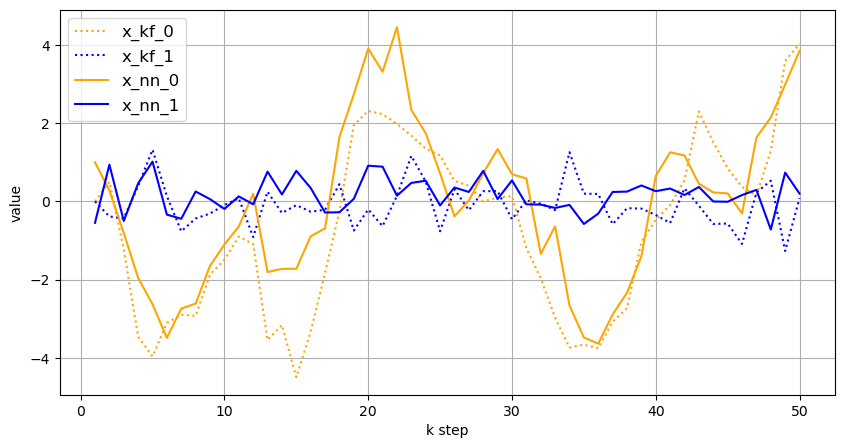

In [20]:

# a = find(pattern,path)

pattern = "./log/single_phy_cov/toy_lgssm/VAE-RNN-PHY_None/toy_lgssm_h80_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

x_kf_0 = x_kalman[0]
x_kf_1 = x_kalman[1]
x_nn_0 = df["z_0"]
x_nn_1 = df["z_1"]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)

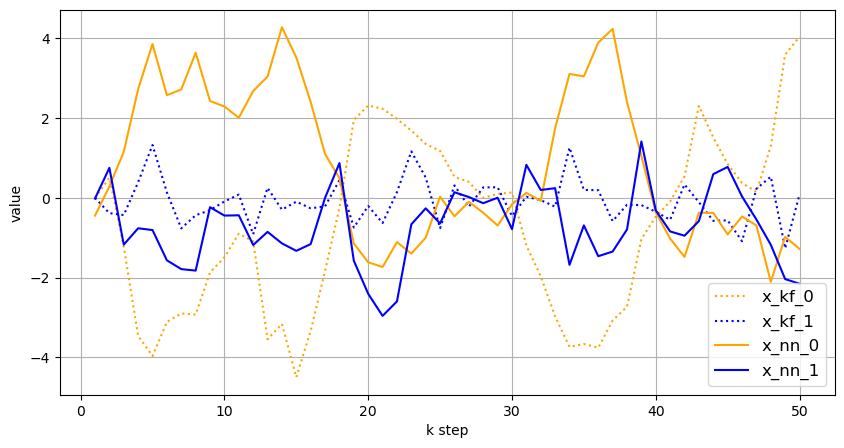

In [21]:

# a = find(pattern,path)

pattern = "./log/single_phy_idmaC/toy_lgssm/VAE-RNN_None/toy_lgssm_h80_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

x_kf_0 = x_kalman[0]
x_kf_1 = x_kalman[1]
x_nn_0 = df["z_0"]
x_nn_1 = df["z_1"]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)

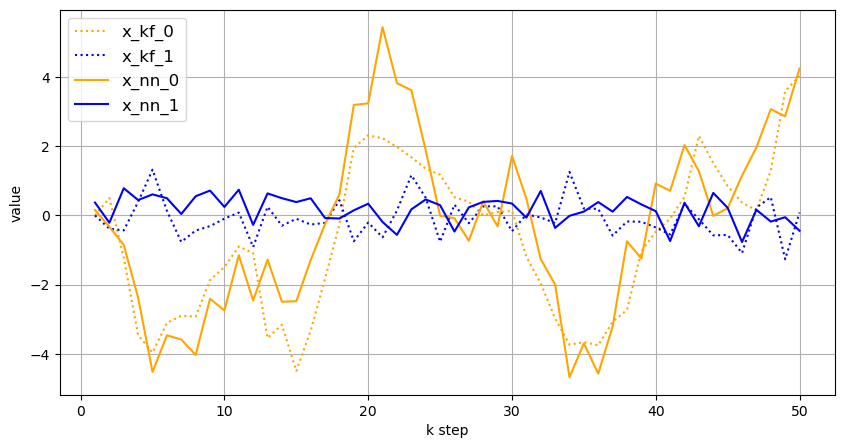

In [23]:

# a = find(pattern,path)

pattern = "./log/single_phy_idmaC/toy_lgssm/VAE-RNN-PHY_None/toy_lgssm_h60_z2_n1.csv"

df = pd.read_csv(pattern)
df.head()

x_kf_0 = x_kalman[0]
x_kf_1 = x_kalman[1]
x_nn_0 = df["z_0"]
x_nn_1 = df["z_1"]

plot_k_nn_x(x_kf_0,x_kf_1,x_nn_0,x_nn_1, length=50)

### different noises

In [ ]:
A = np.array([[0.7, 0.8], [0, 0.1]])
B = np.array([[-1], [0.1]])
C = np.array([[1], [0]]).transpose()
Q = np.sqrt(0.25) * np.identity(2)
R = np.sqrt(1) * np.identity(1)

### generate the command runing the python script several times

In [60]:
command = ""
for model_name in model_names:
    for known_parameter in ['None', 'B']:
        command += "python main_single.py --model \"{}\" --known_parameter \"{}\"\n".format(model_name, known_parameter)
        
myBat = open(r'sameinput_multi.bat','w+')
myBat.write(command)
myBat.close()


In [ ]:


def read_single_output_RMSE_log(path_general, options):
    path_RMSE_log = path_general+"RSME.csv"
    if exists(path_RMSE_log):
        RMSE_log = pd.read_csv(path_RMSE_log)
    else:                                
        generate_output_RMSE_log(path_general,options)
        
def get_more_test(options, path_general, file_name_general):
    available_RMSE = read_single_output_RMSE_log(path_general)

- read from csv file and plot the result?

In [25]:
# set the path
# project_path = "/log_Server/final/toy_lgssm"
project_path = "log/multi_correct_para/toy_lgssm/"
model_names = ['VAE-RNN', 'VRNN-Gauss', 'VRNN-Gauss-I', 'VRNN-GMM', 'VRNN-GMM-I', 'STORN']
para_type = ['B','None']


# generate the list of trained models
output_files = []
model_names_paras = []
rmse_lgssm = {}
for mn in model_names:
    for pt in para_type:
        model_names_para = mn+'_'+pt
        model_names_paras.append(model_names_para)
        
        data_path = (project_path+mn+'_'+pt+"/")
        all_files = os.listdir(data_path)   
        readable_file = data_path +  list(filter(lambda f: f.endswith('multitrain.csv'), all_files))[0]
        print(readable_file)
        
        df = pd.read_csv(readable_file)
        rmse_lgssm[model_names_para] = df["rmse"].mean()
        
        output_files.append(readable_file)
    

log/multi_correct_para/toy_lgssm/VAE-RNN_B/toy_lgssm_h80_z10_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VAE-RNN_None/toy_lgssm_h80_z10_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-Gauss_B/toy_lgssm_h80_z2_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-Gauss_None/toy_lgssm_h80_z2_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-Gauss-I_B/toy_lgssm_h50_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-Gauss-I_None/toy_lgssm_h50_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-GMM_B/toy_lgssm_h50_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-GMM_None/toy_lgssm_h50_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-GMM-I_B/toy_lgssm_h70_z10_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/VRNN-GMM-I_None/toy_lgssm_h70_z10_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/STORN_B/toy_lgssm_h60_z5_n1_multitrain.csv
log/multi_correct_para/toy_lgssm/STORN_None/toy_lgssm_h60_z5_n1_multitrain.csv


In [26]:
sorted_rmse_lgssm={k: v for k, v in sorted(rmse_lgssm.items(), key=lambda item: item[1])}

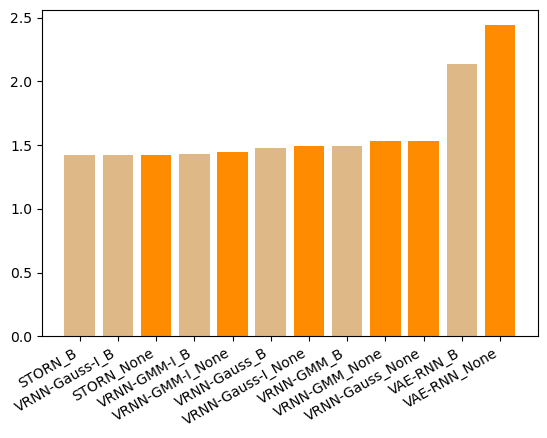

In [27]:

fig, ax = plt.subplots()

colors = []
for m in list(sorted_rmse_lgssm.keys()):
    if m.endswith('B'):
        colors.append("burlywood")
    else:
        colors.append("darkorange")
ax.bar(list(sorted_rmse_lgssm.keys()), list(sorted_rmse_lgssm.values()),color = colors)
fig.autofmt_xdate()
plt.show()

In [28]:
print(list(sorted_rmse_lgssm.values()))

[1.4188597453486662, 1.4224553157094477, 1.4250652253477856, 1.4270555641899896, 1.4442504061640227, 1.476195338737786, 1.4900349437337612, 1.4945988635356704, 1.531030633737399, 1.5314691034502328, 2.1335312130438195, 2.438333051008554]


In [29]:
print(list(sorted_rmse_lgssm.keys()))

['STORN_B', 'VRNN-Gauss-I_B', 'STORN_None', 'VRNN-GMM-I_B', 'VRNN-GMM-I_None', 'VRNN-Gauss_B', 'VRNN-Gauss-I_None', 'VRNN-GMM_B', 'VRNN-GMM_None', 'VRNN-Gauss_None', 'VAE-RNN_B', 'VAE-RNN_None']
